# Examples using text features

In [1]:
import re
import pymongo as py
import pandas as pd
import numpy as np
import pprint
import spacy

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import linear_kernel
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib  import rcParams
rcParams['figure.figsize']=(12,7)

## Retrieve and clean the features

Connect to MongoDB

In [2]:
client = py.MongoClient('mongo')
db = client['docs']
col = db['aug_meta']

Find and retrieve all records that have glove based document vectors and store them in a dataframe.

In [3]:
docs = col.find({"ml-features.glove": {"$exists": True} }, {'_id':1, 'content':1, 'ml-features.glove':1})

df = pd.DataFrame(list(docs))

Clean up the data within the dataframe.

In [4]:
def normalise(vec):
    '''Normalise a vector.'''
    
    norm = np.linalg.norm(vec)
    if norm < 1e-9:
        return vec
    else:
        return vec / norm

In [5]:
df['_id'] = df["_id"].apply(lambda x: str(x))
df['ml-features'] = df['ml-features'].apply(lambda x: np.array(x['glove']))
df['normalised'] = df['ml-features'].apply(lambda x: normalise(x))
df.head()

,_id,content,ml-features,normalised
0,5b4d9faf28172b00206d8cf6,\nIMA\n11/15/2005\n2005 & 2006 Tax Planning In...,"[-0.20181617140769958, 0.15911684930324554, -0...","[-0.06371232816672792, 0.050232371612998525, -..."
1,5b4d9faf38420b000821be91,\nPhotolytic Destruction of Pesticides in Coa...,"[-0.12985067069530487, 0.13325496017932892, -0...","[-0.04740761110947569, 0.0486504944238129, -0...."
2,5b4d9fb086363500209685b8,¿Qué es el Tratamiento para el Abuso de Sustan...,"[0.18963491916656494, -0.4577488303184509, 0.0...","[0.04312094872285554, -0.10408717933837781, 0...."
3,5b4d9fb038420b0035106f4a,"<document>\n<doctype type=""SYLLABUS"">\n<dochea...","[-0.0692429468035698, 0.08693049103021622, -0....","[-0.02633793452879426, 0.03306574441155548, -0..."
4,5b4d9fb0863635006143082f,SUBENT A0614001 19990621 20050616 ...,"[-0.029205935075879097, 0.28353092074394226, 0...","[-0.011500609040592719, 0.1116477956252257, 0...."


## Find the most similiar documents to a given document

First define a function.

In [6]:
def find_most_similiar(_id, id_col, norm_col):
    ''' Find most similiar document
    
        Inputs:
            _id: string id of document of interest
            id_col: pands column of ids
            norm_col: pandas colums of features
        Output:
            array of three most similiar document ids
    '''
    # Convert columns to lists
    id_vec = np.array(id_col.tolist())
    norm_vec = np.array(norm_col.tolist())
    index = np.argwhere(id_vec == _id)[0][0]
    
    # Get vector of interest
    reference = norm_vec[index].reshape(-1,1)
    
    # Compute similarities
    kern = linear_kernel(reference.T, norm_vec)
    
    # Find second most similiar
    most_sim = np.argsort(kern.flatten())[-5:-2]
    
    ids = id_vec[most_sim].tolist()
    ids.reverse()
    
    return ids

Provide a reference document and look at the most similiar documents.

In [7]:
# Print the text of the document you are interested in
id_orig = "5b4d9faf38420b000821be91"
print("Original text:")
text_sample = df.loc[df['_id']==id_orig,  'content'].tolist()[0][0:150]
text_sample = re.sub(r"[\n\r ]+",r" ", text_sample)
print(text_sample)

# Find the ids of the 3 most similiar documents
ids_sim = find_most_similiar(id_orig, df["_id"], df["normalised"])

# Print the text of the most similiar documents
for num, id_sim in enumerate(ids_sim):
    print("\n\n")
    print("Most similiar text: ", num)
    print("\n")
    text_sample = df.loc[df['_id']==id_sim,  'content'].tolist()[0][0:350]
    text_sample = re.sub(r"[\n\r ]+",r" ", text_sample)
    print(text_sample)

Original text:
 Photolytic Destruction of Pesticides in Coastal WetlandsProject Title: Page 1GLNPO ID: GL2000-251 Name of Organization: Type of Organization: Co



Most similiar text:  0


 LITANI WATER QUALITY MANAGEMENT PROJECT RAPID REVIEW REPORT JANUARY 2005 LITANI BASIN MANAGEMENT ADVISORY SERVICES (BAMAS) BUREAU FOR ASIA AND THE NEAR EAST U.S. AGENCY FOR INTERNATIONAL DEVELOPMENT i REPORT PREPARATION This report was prepared by Development Alternatives, Inc. (DAI), 7250 Wo



Most similiar text:  1


Determination of Nitrogen Effects for ExxonMobil The following provides a brief discussion of the potential adverse effects to leafy prairie clover, and eastern prairie fringed orchid from Nitrogen deposition. Information provided by ExxonMobil raises two questions: 1) Is 1g/m2/yr an appropriate threshold value above which we would conclude tha



Most similiar text:  2


 	 	[image: Welcome to the web site for NOAA Research, NOAA's Office of Oceanic and Atmospheric Research] 	[image

### Notes:
Reference document: Photolytic Destruction of  Pesticides in Coastal Wetland

First most similiar: LITANI WATER QUALITY MANAGEMENT PROJECT

Second most similiar: Determination of Nitrogen Effects for ExxonMobil

Third most similiar: Welcome to the web site for NOAA Research, NOAA's Office of Oceanic and Atmospheric Research

## Clustering

You can also do clustering.

In [8]:
num_cluseters = 6
clusterer = KMeans(n_clusters=num_cluseters)

labels = clusterer.fit_predict(df['normalised'].tolist())
distances = clusterer.fit_transform(df['normalised'].tolist())

### Visualise clusters

Reduce to two dimensions for visualisation.

In [9]:
#pca = PCA(n_components=2)
#X_2d = pca.fit_transform(df['normalised'].tolist())
tsne = TSNE(n_components=2, random_state=40)
X_2d = tsne.fit_transform(df['normalised'].tolist())

In [10]:
lab2col = {0:'#1f77b4', 
           1:'#ff7f0e', 
           2:'#2ca02c', 
           3:'#d62728',
           4:'#9467bd',
           5:'#8c564b'}
          
colour_labels = [lab2col[label] for label in labels]


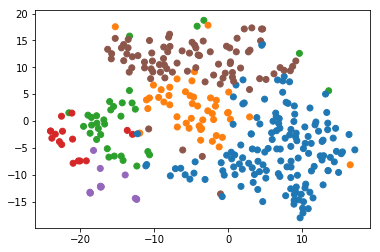

In [11]:
plt.scatter(X_2d[:,0], X_2d[:,1], c=colour_labels)
plt.show()

### Exploring the clusters

Use SpaCy to clean up the text of each cluster and add lables to dataframe.

In [12]:
model_path = '/data/spacy/en_core_web_lg/en_core_web_lg/en_core_web_lg-2.0.0/'
nlp = spacy.load(model_path)

# Fix spaCy bug
for word in nlp.Defaults.stop_words:
    lex = nlp.vocab[word]
    lex.is_stop = True

df['cluster'] = labels

Create word clouds of a given cluster

In [13]:
def clean(text):
    processed_text = nlp(text.lower())
    output = []
    for word in processed_text:
        if word.has_vector and not any([word.is_stop, word.is_digit, word.is_punct]):
            output.append(word.text)
    output = list(set(output))
    return ' '.join(output)


def wc_cluster(cluster):
    
    print("Word cloud for cluster:", cluster)
    
    # Extract
    text = df[df['cluster']==cluster]['content'].apply(clean).tolist()

    # Join the strings together
    combined_text = ' '.join(text)

    # Display a word cloud
    wc = WordCloud(random_state=42).generate( combined_text )
    plt.figure(figsize=(12,10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()    

Word cloud for cluster: 4


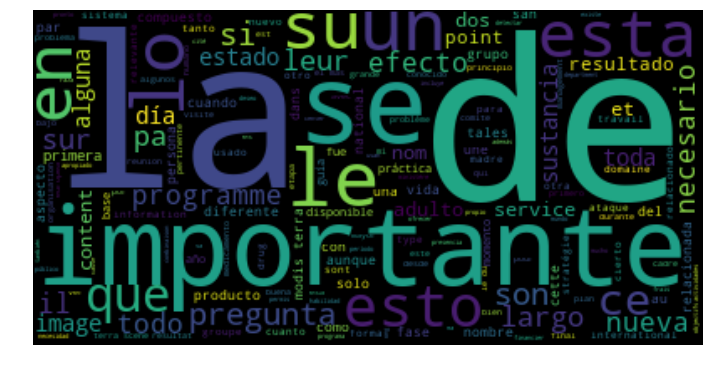

In [14]:
wc_cluster(4)

Extract the documents closest to the cluster centre.

In [15]:
cluster=0

# Find closest clusters
distance_cluster = distances[:, cluster]
closest = np.argsort(distance_cluster)[::][:7]
print(closest)

# Print nicely
for index, row in df.iloc[closest].iterrows():
    print(re.sub(r"[ \n\r]+" ,r" ", row['content'])[0:500])
    print()

[274 283 260 303   1 221 268]
 HETA 94-0122-2578 Bath Iron Works Corporation Bath, Maine David C. Sylvain, M.S., CIH This Health Hazard Evaluation (HHE) report and any recommendations made herein are for the specific facility evaluated and may not be universally applicable. Any recommendations made are not to be considered as final statements of NIOSH policy or of any agency or individual involved. Additional HHE reports are available at http://www.cdc.gov/niosh/hhe/reports This Health Hazard Evaluation (HHE) report and any 

 	[image: Official Web page of the U S Fish and Wildlife Service]   Ashland NFWCO Midwest Region 	 [image: MTAN Home Page] Dedicated To The Tribal Aquaculture Program 	[image: Image of fish jumping.]	 September 2002-Volume 41   	 Administrative Coordinator: Frank G. Stone  (715-682-6185) Ext. 202 U.S. Fish and Wildlife Service Email: Frank_Stone@fws.gov 	 Edited By: Elizabeth W. Greiff  (715-349-2195) Ext. 141 St. Croix Tribal Nat. Res. Depart. Email:  bethg@stcro